## Localization vs Non-localization Rates by Imaging Modality

In [26]:
import pandas as pd 
import matplotlib.pyplot as plt
preop_imaging_df = pd.read_excel('Data/final_clean_imaging_data.xlsx')

In [27]:
# initalize the modalities 
modalities = ['SPECT/CT', '4D CT Scan', 'Ultrasound', 'Sestamibi', 'MRI']

# create dictionaries to store the counts 
non_localizing_counts = {}
localizing_counts = {}
non_localizing_rates = {}
localizing_rates = {}

In [28]:
# iterate through each modality 
for modality in modalities:
    
    # calculate non-localizing
    non_localizing_count = preop_imaging_df[preop_imaging_df[modality] == 'Non-localizing'].shape[0]
    # store this in the respective dictionary
    non_localizing_counts[modality] = non_localizing_count
    
    # count the localized scans (not non-localizing or no scan)
    localizing_count = preop_imaging_df[
            preop_imaging_df[modality].notnull() & 
            (preop_imaging_df[modality] != 'Non-localizing') & 
            (preop_imaging_df[modality] != 'No Scan')
        ].shape[0]
    # add to the respective dictionary 
    localizing_counts[modality] = localizing_count

    # calculate total scans 
    total_scans = non_localizing_count + localizing_count
    
    # Calculate non-localization rate
    non_localizing_rates[modality] = round((non_localizing_count / total_scans * 100) if total_scans > 0 else 0, 2)
    localizing_rates[modality] = round((localizing_count / total_scans * 100) if total_scans > 0 else 0, 2)

print(localizing_rates)
print(non_localizing_rates)

{'SPECT/CT': 77.39, '4D CT Scan': 75.88, 'Ultrasound': 53.79, 'Sestamibi': 64.94, 'MRI': 53.33}
{'SPECT/CT': 22.61, '4D CT Scan': 24.12, 'Ultrasound': 46.21, 'Sestamibi': 35.06, 'MRI': 46.67}


In [29]:
# convert to a dataframe for better output 
# Convert to DataFrame
summary_df = pd.DataFrame({
    'Non-localizing': non_localizing_counts,
    'Localizing': localizing_counts,
    'Non-localization Rate (%)': non_localizing_rates,
    'Localization Rate (%)': localizing_rates
})

summary_df

,Non-localizing,Localizing,Non-localization Rate (%),Localization Rate (%)
SPECT/CT,52,178,22.61,77.39
4D CT Scan,55,173,24.12,75.88
Ultrasound,67,78,46.21,53.79
Sestamibi,61,113,35.06,64.94
MRI,7,8,46.67,53.33


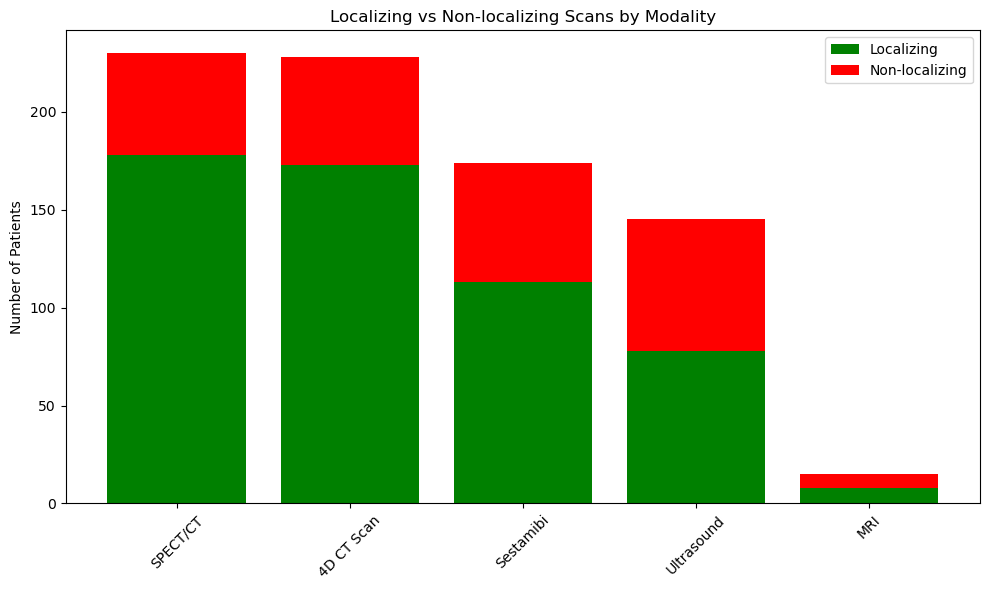

In [30]:
# Convert to series 
localizing_series = pd.Series(localizing_counts)
non_localizing_series = pd.Series(non_localizing_counts)
loc_rate_series = pd.Series(localizing_rates)  

# Sort modalities
sorted_modalities = loc_rate_series.sort_values(ascending=False).index
localizing_series = localizing_series[sorted_modalities]
non_localizing_series = non_localizing_series[sorted_modalities]

# initialize figure size
plt.figure(figsize=(10,6))

# Plot directly from the Series
plt.bar(localizing_series.index, localizing_series, label='Localizing', color='green')
plt.bar(non_localizing_series.index, non_localizing_series, 
        bottom=localizing_series, label='Non-localizing', color='red')

# titles 
plt.ylabel('Number of Patients')
plt.title('Localizing vs Non-localizing Scans by Modality')
# rotate x-axis labels 
plt.xticks(rotation=45)
plt.legend()
# space it out better 
plt.tight_layout()
plt.show()

## Success Evaluation

Patients were labeled "Success" if they were cured and had at least one concordant imaging modality (Exact or Side match).


In [32]:
success_rates = {}
success_counts = {}
total_scanned_counts = {}

for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'

    # Include only rows where the scan was done (exclude Unknown / No Scan)
    scanned = preop_imaging_df[
        preop_imaging_df[concordance_col].notna() &
        (~preop_imaging_df[concordance_col].isin(['Unknown', 'No Scan']))
    ]

    # Total valid scans (localized or not)
    total_scanned = scanned.shape[0]
    total_scanned_counts[modality] = total_scanned

    # Define success: concordant (exact or side) AND cured
    success = scanned[
        scanned[concordance_col].isin(['Yes (Exact)', 'Yes (Side)']) &
        (scanned['Surgical Cure'].str.strip().str.lower() == 'yes')
    ]

    success_count = success.shape[0]
    success_counts[modality] = success_count

    success_rate = round((success_count / total_scanned) * 100, 2) if total_scanned > 0 else 0
    success_rates[modality] = success_rate

# Combine into DataFrame
success_df = pd.DataFrame({
    'Total Scanned': total_scanned_counts,
    'Concordant + Cured': success_counts,
    'Success Rate (%)': success_rates
})

display(success_df)

,Total Scanned,Concordant + Cured,Success Rate (%)
SPECT/CT,230,153,66.52
4D CT Scan,228,133,58.33
Ultrasound,145,67,46.21
Sestamibi,174,107,61.49
MRI,15,6,40.00


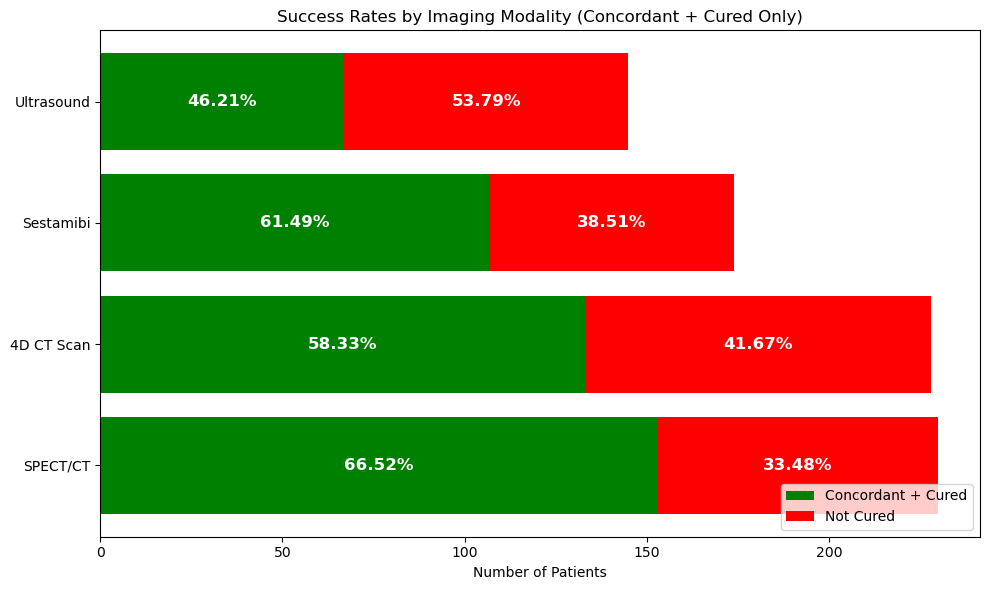

In [ ]:
# Create dataframe from earlier success logic
success_df = pd.DataFrame({
    'Modality': list(success_counts.keys()),
    'Total Scanned': list(total_scanned_counts.values()),
    'Concordant + Cured': list(success_counts.values())
})

# Remove MRI
success_df = success_df[success_df['Modality'] != 'MRI'].copy()

# Calculate Not Cured
success_df['Not Cured'] = success_df['Total Scanned'] - success_df['Concordant + Cured']

# Calculate success rate
success_df['Success Rate (%)'] = round((success_df['Concordant + Cured'] / success_df['Total Scanned']) * 100, 2)

# Reorder manually: Best at top, 4D CT Scan second to bottom, worst at bottom
desired_order = ['Ultrasound', 'Sestamibi', '4D CT Scan', 'SPECT/CT']
sorted_df = success_df.set_index('Modality').reindex(desired_order).reset_index()

# Pull data for plotting
modalities = sorted_df['Modality'].tolist()
cured = sorted_df['Concordant + Cured'].tolist()
not_cured = sorted_df['Not Cured'].tolist()
success_rates = sorted_df['Success Rate (%)'].tolist()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(modalities))

# Green and red stacked bars
ax.barh(y_pos, cured, color='green', label='Concordant + Cured')
ax.barh(y_pos, not_cured, left=cured, color='red', label='Not Cured')

# Success and failure rate labels
for i in range(len(modalities)):
    # Green success %
    ax.text(cured[i]/2, i, f'{success_rates[i]}%', va='center', ha='center',
            fontweight='bold', color='white', fontsize=12)

    # Red failure % (100 - success)
    fail_rate = round(100 - success_rates[i], 2)
    if not_cured[i] > 0:
        ax.text(cured[i] + not_cured[i]/2, i, f'{fail_rate}%', va='center', ha='center',
                fontweight='bold', color='white', fontsize=12)


# Labels and style
ax.set_yticks(y_pos)
ax.set_yticklabels(modalities)
ax.set_xlabel('Number of Patients')
ax.set_title('Success Rates by Imaging Modality (Concordant + Cured Only)')
ax.legend(loc='lower right')
ax.invert_yaxis()
plt.tight_layout()
plt.show()